# Train an Agent using Adversarial Inverse Reinforcement Learning


As usual, we first need an expert. 
Note that we now use a variant of the CartPole environment from the seals package, which has fixed episode durations. Read more about why we do this [here](https://imitation.readthedocs.io/en/latest/guide/variable_horizon.html).

In [10]:
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
import gym
import seals

env = gym.make("seals/CartPole-v0")
expert = PPO(
    policy=MlpPolicy,
    env=env,
    seed=0,
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0003,
    n_epochs=10,
    n_steps=64,
    device='cpu'
)
expert.learn(100000)  # Note: set to 100000 to train a proficient expert

/root/anaconda3/envs/CI/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


We generate some expert trajectories, that the discriminator needs to distinguish from the learner's trajectories.

In [11]:
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.vec_env import DummyVecEnv

rollouts = rollout.rollout(
    expert,
    DummyVecEnv([lambda: RolloutInfoWrapper(gym.make("seals/CartPole-v0"))] * 5),
    rollout.make_sample_until(min_timesteps=None, min_episodes=60),
)

/root/anaconda3/envs/CI/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Now we are ready to set up our AIRL trainer.
Note, that the `reward_net` is actually the network of the discriminator.
We evaluate the learner before and after training so we can see if it made any progress.

In [23]:
from imitation.algorithms.adversarial.airl import AIRL
from imitation.rewards.reward_nets import BasicShapedRewardNet
from imitation.util.networks import RunningNorm
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

from stable_baselines3.ppo import MlpPolicy
import gym
import seals

venv = DummyVecEnv([lambda: gym.make("seals/CartPole-v0")] * 8)
learner = PPO(
    env=venv,
    policy=MlpPolicy,
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0003,
    n_epochs=10,
    device='cpu'
)
reward_net = BasicShapedRewardNet(
    venv.observation_space, venv.action_space, normalize_input_layer=RunningNorm
)
airl_trainer = AIRL(
    demonstrations=rollouts,
    demo_batch_size=1024,
    gen_replay_buffer_capacity=2048,
    n_disc_updates_per_round=4,
    venv=venv,
    gen_algo=learner,
    reward_net=reward_net,
)

learner_rewards_before_training, _ = evaluate_policy(
    learner, venv, 100, return_episode_rewards=True
)
airl_trainer.train(int(1.4e6))  # Note: set to 300000 for better results
learner_rewards_after_training, _ = evaluate_policy(
    learner, venv, 100, return_episode_rewards=True
)

/root/anaconda3/envs/CI/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/root/anaconda3/envs/CI/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
round:   0%|          | 0/85 [00:00<?, ?it/s]

---------------------------------------
| raw/                        |       |
|    gen/time/fps             | 7298  |
|    gen/time/iterations      | 1     |
|    gen/time/time_elapsed    | 2     |
|    gen/time/total_timesteps | 16384 |
---------------------------------------
--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.51     |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0.0195   |
|    disc/disc_entropy                | 0.639    |
|    disc/disc_loss                   | 0.768    |
|    disc/disc_proportion_expert_pred | 0.99     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 1        |
|    disc/n_expert                    | 1.02e+03 |
|    disc/n_generated                 | 1.02e+03 |
--------------------------------------------------
--------------------------------------------------
| raw/

round:   1%|          | 1/85 [00:10<14:49, 10.59s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | 85.3        |
|    gen/time/fps                    | 7283        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 32768       |
|    gen/train/approx_kl             | 0.010808822 |
|    gen/train/clip_fraction         | 0.0462      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.682      |
|    gen/train/explained_variance    | 0.0439      |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 57.3        |
|    gen/train/n_updates             | 10          |
|    gen/train/policy_gradient_loss  | -0.00404    |
|    gen/train/value_loss            | 124         |
----------------------------------------------------
----------------------------------------------

round:   2%|▏         | 2/85 [00:21<14:35, 10.55s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | 42.5        |
|    gen/time/fps                    | 7413        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 49152       |
|    gen/train/approx_kl             | 0.015419666 |
|    gen/train/clip_fraction         | 0.226       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.663      |
|    gen/train/explained_variance    | 0.937       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.622       |
|    gen/train/n_updates             | 20          |
|    gen/train/policy_gradient_loss  | -0.0162     |
|    gen/train/value_loss            | 3.04        |
----------------------------------------------------
----------------------------------------------

round:   4%|▎         | 3/85 [00:31<14:28, 10.59s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | 32.3        |
|    gen/time/fps                    | 6328        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 65536       |
|    gen/train/approx_kl             | 0.009970162 |
|    gen/train/clip_fraction         | 0.111       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.656      |
|    gen/train/explained_variance    | 0.926       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 1.22        |
|    gen/train/n_updates             | 30          |
|    gen/train/policy_gradient_loss  | -0.0114     |
|    gen/train/value_loss            | 2.15        |
----------------------------------------------------
----------------------------------------------

round:   5%|▍         | 4/85 [00:44<15:24, 11.42s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | 12.8        |
|    gen/time/fps                    | 6364        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 81920       |
|    gen/train/approx_kl             | 0.017812844 |
|    gen/train/clip_fraction         | 0.193       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.636      |
|    gen/train/explained_variance    | 0.904       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.432       |
|    gen/train/n_updates             | 40          |
|    gen/train/policy_gradient_loss  | -0.0198     |
|    gen/train/value_loss            | 1.12        |
----------------------------------------------------
----------------------------------------------

round:   6%|▌         | 5/85 [00:57<15:48, 11.85s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -13.8       |
|    gen/time/fps                    | 6382        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 98304       |
|    gen/train/approx_kl             | 0.015534648 |
|    gen/train/clip_fraction         | 0.175       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.608      |
|    gen/train/explained_variance    | 0.884       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.265       |
|    gen/train/n_updates             | 50          |
|    gen/train/policy_gradient_loss  | -0.0136     |
|    gen/train/value_loss            | 1.04        |
----------------------------------------------------
----------------------------------------------

round:   7%|▋         | 6/85 [01:08<15:15, 11.58s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -47.9       |
|    gen/time/fps                    | 7329        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 114688      |
|    gen/train/approx_kl             | 0.010987187 |
|    gen/train/clip_fraction         | 0.142       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.585      |
|    gen/train/explained_variance    | 0.801       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.586       |
|    gen/train/n_updates             | 60          |
|    gen/train/policy_gradient_loss  | -0.00861    |
|    gen/train/value_loss            | 1.22        |
----------------------------------------------------
----------------------------------------------

round:   8%|▊         | 7/85 [01:18<14:40, 11.29s/it]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_rew_wrapped_mean | -90.7    |
|    gen/time/fps                    | 7315     |
|    gen/time/iterations             | 1        |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 131072   |
|    gen/train/approx_kl             | 0.008762 |
|    gen/train/clip_fraction         | 0.102    |
|    gen/train/clip_range            | 0.2      |
|    gen/train/entropy_loss          | -0.569   |
|    gen/train/explained_variance    | 0.643    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/loss                  | 0.255    |
|    gen/train/n_updates             | 70       |
|    gen/train/policy_gradient_loss  | -0.0045  |
|    gen/train/value_loss            | 1.53     |
-------------------------------------------------
--------------------------------------------------
| raw/                                |          

round:   9%|▉         | 8/85 [01:29<14:11, 11.06s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -139        |
|    gen/time/fps                    | 7430        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 147456      |
|    gen/train/approx_kl             | 0.009635013 |
|    gen/train/clip_fraction         | 0.11        |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.545      |
|    gen/train/explained_variance    | 0.508       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.754       |
|    gen/train/n_updates             | 80          |
|    gen/train/policy_gradient_loss  | -0.00451    |
|    gen/train/value_loss            | 1.68        |
----------------------------------------------------
----------------------------------------------

round:  11%|█         | 9/85 [01:39<13:35, 10.73s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -185        |
|    gen/time/fps                    | 7357        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 163840      |
|    gen/train/approx_kl             | 0.009968425 |
|    gen/train/clip_fraction         | 0.101       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.526      |
|    gen/train/explained_variance    | 0.467       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.831       |
|    gen/train/n_updates             | 90          |
|    gen/train/policy_gradient_loss  | -0.00434    |
|    gen/train/value_loss            | 1.64        |
----------------------------------------------------
----------------------------------------------

round:  12%|█▏        | 10/85 [01:50<13:22, 10.70s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -222        |
|    gen/time/fps                    | 7287        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 180224      |
|    gen/train/approx_kl             | 0.009183392 |
|    gen/train/clip_fraction         | 0.111       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.517      |
|    gen/train/explained_variance    | 0.63        |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.159       |
|    gen/train/n_updates             | 100         |
|    gen/train/policy_gradient_loss  | -0.00667    |
|    gen/train/value_loss            | 1.47        |
----------------------------------------------------
----------------------------------------------

round:  13%|█▎        | 11/85 [02:00<13:04, 10.61s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -260        |
|    gen/time/fps                    | 7302        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 196608      |
|    gen/train/approx_kl             | 0.009953957 |
|    gen/train/clip_fraction         | 0.127       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.499      |
|    gen/train/explained_variance    | 0.783       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.401       |
|    gen/train/n_updates             | 110         |
|    gen/train/policy_gradient_loss  | -0.0078     |
|    gen/train/value_loss            | 1.47        |
----------------------------------------------------
----------------------------------------------

round:  14%|█▍        | 12/85 [02:10<12:51, 10.56s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_rew_wrapped_mean | -288       |
|    gen/time/fps                    | 6950       |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 2          |
|    gen/time/total_timesteps        | 212992     |
|    gen/train/approx_kl             | 0.01118519 |
|    gen/train/clip_fraction         | 0.121      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.492     |
|    gen/train/explained_variance    | 0.87       |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | 0.553      |
|    gen/train/n_updates             | 120        |
|    gen/train/policy_gradient_loss  | -0.00715   |
|    gen/train/value_loss            | 1.44       |
---------------------------------------------------
--------------------------------------------------
| raw/       

round:  15%|█▌        | 13/85 [02:21<12:42, 10.59s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -310        |
|    gen/time/fps                    | 7440        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 229376      |
|    gen/train/approx_kl             | 0.012600613 |
|    gen/train/clip_fraction         | 0.155       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.495      |
|    gen/train/explained_variance    | 0.93        |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.591       |
|    gen/train/n_updates             | 130         |
|    gen/train/policy_gradient_loss  | -0.011      |
|    gen/train/value_loss            | 1.38        |
----------------------------------------------------
----------------------------------------------

round:  16%|█▋        | 14/85 [02:31<12:22, 10.46s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | -325         |
|    gen/time/fps                    | 7435         |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 245760       |
|    gen/train/approx_kl             | 0.0118994145 |
|    gen/train/clip_fraction         | 0.154        |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.47        |
|    gen/train/explained_variance    | 0.935        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 0.358        |
|    gen/train/n_updates             | 140          |
|    gen/train/policy_gradient_loss  | -0.013       |
|    gen/train/value_loss            | 1.28         |
-----------------------------------------------------
----------------------------

round:  18%|█▊        | 15/85 [02:42<12:16, 10.53s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -336        |
|    gen/time/fps                    | 7400        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 262144      |
|    gen/train/approx_kl             | 0.017530438 |
|    gen/train/clip_fraction         | 0.167       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.432      |
|    gen/train/explained_variance    | 0.927       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.505       |
|    gen/train/n_updates             | 150         |
|    gen/train/policy_gradient_loss  | -0.0142     |
|    gen/train/value_loss            | 1.3         |
----------------------------------------------------
----------------------------------------------

round:  19%|█▉        | 16/85 [02:53<12:09, 10.57s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -346        |
|    gen/time/fps                    | 7480        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 278528      |
|    gen/train/approx_kl             | 0.017890725 |
|    gen/train/clip_fraction         | 0.139       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.398      |
|    gen/train/explained_variance    | 0.937       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.507       |
|    gen/train/n_updates             | 160         |
|    gen/train/policy_gradient_loss  | -0.0114     |
|    gen/train/value_loss            | 1.12        |
----------------------------------------------------
----------------------------------------------

round:  20%|██        | 17/85 [03:03<11:54, 10.51s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -357        |
|    gen/time/fps                    | 7458        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 294912      |
|    gen/train/approx_kl             | 0.015217442 |
|    gen/train/clip_fraction         | 0.113       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.388      |
|    gen/train/explained_variance    | 0.95        |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.314       |
|    gen/train/n_updates             | 170         |
|    gen/train/policy_gradient_loss  | -0.0098     |
|    gen/train/value_loss            | 0.98        |
----------------------------------------------------
----------------------------------------------

round:  21%|██        | 18/85 [03:13<11:42, 10.48s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -364        |
|    gen/time/fps                    | 7420        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 311296      |
|    gen/train/approx_kl             | 0.017953943 |
|    gen/train/clip_fraction         | 0.143       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.368      |
|    gen/train/explained_variance    | 0.961       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.293       |
|    gen/train/n_updates             | 180         |
|    gen/train/policy_gradient_loss  | -0.0145     |
|    gen/train/value_loss            | 0.815       |
----------------------------------------------------
----------------------------------------------

round:  22%|██▏       | 19/85 [03:24<11:31, 10.47s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -367        |
|    gen/time/fps                    | 7450        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 327680      |
|    gen/train/approx_kl             | 0.020011432 |
|    gen/train/clip_fraction         | 0.158       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.345      |
|    gen/train/explained_variance    | 0.964       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.49        |
|    gen/train/n_updates             | 190         |
|    gen/train/policy_gradient_loss  | -0.0172     |
|    gen/train/value_loss            | 0.77        |
----------------------------------------------------
----------------------------------------------

round:  24%|██▎       | 20/85 [03:34<11:23, 10.52s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -368        |
|    gen/time/fps                    | 7395        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 344064      |
|    gen/train/approx_kl             | 0.020942785 |
|    gen/train/clip_fraction         | 0.168       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.338      |
|    gen/train/explained_variance    | 0.955       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.274       |
|    gen/train/n_updates             | 200         |
|    gen/train/policy_gradient_loss  | -0.0199     |
|    gen/train/value_loss            | 0.777       |
----------------------------------------------------
----------------------------------------------

round:  25%|██▍       | 21/85 [03:45<11:13, 10.53s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -364        |
|    gen/time/fps                    | 7424        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 360448      |
|    gen/train/approx_kl             | 0.024647601 |
|    gen/train/clip_fraction         | 0.193       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.36       |
|    gen/train/explained_variance    | 0.942       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.541       |
|    gen/train/n_updates             | 210         |
|    gen/train/policy_gradient_loss  | -0.0218     |
|    gen/train/value_loss            | 1.04        |
----------------------------------------------------
----------------------------------------------

round:  26%|██▌       | 22/85 [03:56<11:05, 10.56s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -357        |
|    gen/time/fps                    | 7418        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 376832      |
|    gen/train/approx_kl             | 0.034377422 |
|    gen/train/clip_fraction         | 0.251       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.408      |
|    gen/train/explained_variance    | 0.93        |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.333       |
|    gen/train/n_updates             | 220         |
|    gen/train/policy_gradient_loss  | -0.0276     |
|    gen/train/value_loss            | 1.12        |
----------------------------------------------------
----------------------------------------------

round:  27%|██▋       | 23/85 [04:05<10:41, 10.35s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -330        |
|    gen/time/fps                    | 7366        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 393216      |
|    gen/train/approx_kl             | 0.049230777 |
|    gen/train/clip_fraction         | 0.245       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.363      |
|    gen/train/explained_variance    | 0.868       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.682       |
|    gen/train/n_updates             | 230         |
|    gen/train/policy_gradient_loss  | -0.0285     |
|    gen/train/value_loss            | 1.73        |
----------------------------------------------------
----------------------------------------------

round:  28%|██▊       | 24/85 [04:16<10:38, 10.47s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -272        |
|    gen/time/fps                    | 7332        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 409600      |
|    gen/train/approx_kl             | 0.009299598 |
|    gen/train/clip_fraction         | 0.1         |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.427      |
|    gen/train/explained_variance    | 0.967       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 5.39        |
|    gen/train/n_updates             | 240         |
|    gen/train/policy_gradient_loss  | -0.00969    |
|    gen/train/value_loss            | 10.8        |
----------------------------------------------------
----------------------------------------------

round:  29%|██▉       | 25/85 [04:27<10:33, 10.56s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_rew_wrapped_mean | -214       |
|    gen/time/fps                    | 7357       |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 2          |
|    gen/time/total_timesteps        | 425984     |
|    gen/train/approx_kl             | 0.02179088 |
|    gen/train/clip_fraction         | 0.158      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.451     |
|    gen/train/explained_variance    | 0.975      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | 4.62       |
|    gen/train/n_updates             | 250        |
|    gen/train/policy_gradient_loss  | -0.0162    |
|    gen/train/value_loss            | 8.51       |
---------------------------------------------------
--------------------------------------------------
| raw/       

round:  31%|███       | 26/85 [04:38<10:25, 10.60s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -173        |
|    gen/time/fps                    | 7375        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 442368      |
|    gen/train/approx_kl             | 0.014611877 |
|    gen/train/clip_fraction         | 0.155       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.489      |
|    gen/train/explained_variance    | 0.974       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 2.54        |
|    gen/train/n_updates             | 260         |
|    gen/train/policy_gradient_loss  | -0.017      |
|    gen/train/value_loss            | 7.92        |
----------------------------------------------------
----------------------------------------------

round:  32%|███▏      | 27/85 [04:48<10:15, 10.61s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -167        |
|    gen/time/fps                    | 7364        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 458752      |
|    gen/train/approx_kl             | 0.012950495 |
|    gen/train/clip_fraction         | 0.162       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.512      |
|    gen/train/explained_variance    | 0.959       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 1.74        |
|    gen/train/n_updates             | 270         |
|    gen/train/policy_gradient_loss  | -0.0184     |
|    gen/train/value_loss            | 6.14        |
----------------------------------------------------
----------------------------------------------

round:  33%|███▎      | 28/85 [04:59<10:06, 10.65s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -178        |
|    gen/time/fps                    | 7353        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 475136      |
|    gen/train/approx_kl             | 0.019005436 |
|    gen/train/clip_fraction         | 0.198       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.501      |
|    gen/train/explained_variance    | 0.948       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 2.3         |
|    gen/train/n_updates             | 280         |
|    gen/train/policy_gradient_loss  | -0.0175     |
|    gen/train/value_loss            | 3.85        |
----------------------------------------------------
----------------------------------------------

round:  34%|███▍      | 29/85 [05:10<10:06, 10.83s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -210        |
|    gen/time/fps                    | 7401        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 491520      |
|    gen/train/approx_kl             | 0.013878284 |
|    gen/train/clip_fraction         | 0.142       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.477      |
|    gen/train/explained_variance    | 0.965       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 1.08        |
|    gen/train/n_updates             | 290         |
|    gen/train/policy_gradient_loss  | -0.0137     |
|    gen/train/value_loss            | 2.65        |
----------------------------------------------------
----------------------------------------------

round:  35%|███▌      | 30/85 [05:21<09:46, 10.67s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -269        |
|    gen/time/fps                    | 7337        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 507904      |
|    gen/train/approx_kl             | 0.009500911 |
|    gen/train/clip_fraction         | 0.134       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.455      |
|    gen/train/explained_variance    | 0.979       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.749       |
|    gen/train/n_updates             | 300         |
|    gen/train/policy_gradient_loss  | -0.013      |
|    gen/train/value_loss            | 2.95        |
----------------------------------------------------
----------------------------------------------

round:  36%|███▋      | 31/85 [05:31<09:37, 10.70s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_rew_wrapped_mean | -361       |
|    gen/time/fps                    | 7310       |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 2          |
|    gen/time/total_timesteps        | 524288     |
|    gen/train/approx_kl             | 0.01168016 |
|    gen/train/clip_fraction         | 0.126      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.429     |
|    gen/train/explained_variance    | 0.976      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | 2.05       |
|    gen/train/n_updates             | 310        |
|    gen/train/policy_gradient_loss  | -0.00976   |
|    gen/train/value_loss            | 3.78       |
---------------------------------------------------
--------------------------------------------------
| raw/       

round:  38%|███▊      | 32/85 [05:42<09:27, 10.71s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | -504         |
|    gen/time/fps                    | 7323         |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 540672       |
|    gen/train/approx_kl             | 0.0077684023 |
|    gen/train/clip_fraction         | 0.0714       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.394       |
|    gen/train/explained_variance    | 0.936        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 1.5          |
|    gen/train/n_updates             | 320          |
|    gen/train/policy_gradient_loss  | -0.00311     |
|    gen/train/value_loss            | 5.54         |
-----------------------------------------------------
----------------------------

round:  39%|███▉      | 33/85 [05:53<09:17, 10.72s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | -634         |
|    gen/time/fps                    | 7340         |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 557056       |
|    gen/train/approx_kl             | 0.0069465423 |
|    gen/train/clip_fraction         | 0.0605       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.379       |
|    gen/train/explained_variance    | 0.902        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 2.44         |
|    gen/train/n_updates             | 330          |
|    gen/train/policy_gradient_loss  | -0.00183     |
|    gen/train/value_loss            | 6.28         |
-----------------------------------------------------
----------------------------

round:  40%|████      | 34/85 [06:04<09:07, 10.73s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | -758         |
|    gen/time/fps                    | 7434         |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 573440       |
|    gen/train/approx_kl             | 0.0043909433 |
|    gen/train/clip_fraction         | 0.0496       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.381       |
|    gen/train/explained_variance    | 0.813        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 1.5          |
|    gen/train/n_updates             | 340          |
|    gen/train/policy_gradient_loss  | -0.000404    |
|    gen/train/value_loss            | 8.09         |
-----------------------------------------------------
----------------------------

round:  41%|████      | 35/85 [06:14<08:46, 10.52s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -873        |
|    gen/time/fps                    | 7445        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 589824      |
|    gen/train/approx_kl             | 0.005260532 |
|    gen/train/clip_fraction         | 0.0648      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.373      |
|    gen/train/explained_variance    | 0.815       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 1.96        |
|    gen/train/n_updates             | 350         |
|    gen/train/policy_gradient_loss  | 0.000274    |
|    gen/train/value_loss            | 8.87        |
----------------------------------------------------
----------------------------------------------

round:  42%|████▏     | 36/85 [06:24<08:36, 10.54s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | -968         |
|    gen/time/fps                    | 7401         |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 606208       |
|    gen/train/approx_kl             | 0.0052753435 |
|    gen/train/clip_fraction         | 0.0533       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.358       |
|    gen/train/explained_variance    | 0.878        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 1.23         |
|    gen/train/n_updates             | 360          |
|    gen/train/policy_gradient_loss  | -0.000705    |
|    gen/train/value_loss            | 12.7         |
-----------------------------------------------------
----------------------------

round:  44%|████▎     | 37/85 [06:34<08:18, 10.38s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | -1.05e+03    |
|    gen/time/fps                    | 6950         |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 622592       |
|    gen/train/approx_kl             | 0.0064691263 |
|    gen/train/clip_fraction         | 0.0657       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.346       |
|    gen/train/explained_variance    | 0.928        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 3.32         |
|    gen/train/n_updates             | 370          |
|    gen/train/policy_gradient_loss  | -0.001       |
|    gen/train/value_loss            | 16.6         |
-----------------------------------------------------
----------------------------

round:  45%|████▍     | 38/85 [06:45<08:14, 10.53s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | -1.11e+03    |
|    gen/time/fps                    | 7415         |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 638976       |
|    gen/train/approx_kl             | 0.0052683367 |
|    gen/train/clip_fraction         | 0.0583       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.336       |
|    gen/train/explained_variance    | 0.959        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 3.45         |
|    gen/train/n_updates             | 380          |
|    gen/train/policy_gradient_loss  | 0.000302     |
|    gen/train/value_loss            | 16.7         |
-----------------------------------------------------
----------------------------

round:  46%|████▌     | 39/85 [06:56<08:03, 10.51s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -1.14e+03   |
|    gen/time/fps                    | 7314        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 655360      |
|    gen/train/approx_kl             | 0.007271193 |
|    gen/train/clip_fraction         | 0.0631      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.352      |
|    gen/train/explained_variance    | 0.964       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 3.06        |
|    gen/train/n_updates             | 390         |
|    gen/train/policy_gradient_loss  | -0.00206    |
|    gen/train/value_loss            | 11.5        |
----------------------------------------------------
----------------------------------------------

round:  47%|████▋     | 40/85 [07:06<07:47, 10.38s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -1.15e+03   |
|    gen/time/fps                    | 7435        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 671744      |
|    gen/train/approx_kl             | 0.009699348 |
|    gen/train/clip_fraction         | 0.0793      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.354      |
|    gen/train/explained_variance    | 0.971       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 3.14        |
|    gen/train/n_updates             | 400         |
|    gen/train/policy_gradient_loss  | -0.00122    |
|    gen/train/value_loss            | 9.33        |
----------------------------------------------------
----------------------------------------------

round:  48%|████▊     | 41/85 [07:16<07:41, 10.49s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -1.14e+03   |
|    gen/time/fps                    | 7388        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 688128      |
|    gen/train/approx_kl             | 0.014111009 |
|    gen/train/clip_fraction         | 0.113       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.377      |
|    gen/train/explained_variance    | 0.98        |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 1.91        |
|    gen/train/n_updates             | 410         |
|    gen/train/policy_gradient_loss  | -0.00407    |
|    gen/train/value_loss            | 5.9         |
----------------------------------------------------
----------------------------------------------

round:  49%|████▉     | 42/85 [07:27<07:33, 10.55s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -1.1e+03    |
|    gen/time/fps                    | 7404        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 704512      |
|    gen/train/approx_kl             | 0.013259305 |
|    gen/train/clip_fraction         | 0.112       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.369      |
|    gen/train/explained_variance    | 0.977       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 1.05        |
|    gen/train/n_updates             | 420         |
|    gen/train/policy_gradient_loss  | -0.00708    |
|    gen/train/value_loss            | 4.22        |
----------------------------------------------------
----------------------------------------------

round:  51%|█████     | 43/85 [07:37<07:13, 10.33s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -1.07e+03   |
|    gen/time/fps                    | 7251        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 720896      |
|    gen/train/approx_kl             | 0.013396448 |
|    gen/train/clip_fraction         | 0.146       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.387      |
|    gen/train/explained_variance    | 0.976       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 1.15        |
|    gen/train/n_updates             | 430         |
|    gen/train/policy_gradient_loss  | -0.00856    |
|    gen/train/value_loss            | 3.38        |
----------------------------------------------------
----------------------------------------------

round:  52%|█████▏    | 44/85 [07:47<07:02, 10.30s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -1.04e+03   |
|    gen/time/fps                    | 7323        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 737280      |
|    gen/train/approx_kl             | 0.011668373 |
|    gen/train/clip_fraction         | 0.161       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.4        |
|    gen/train/explained_variance    | 0.977       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 1.02        |
|    gen/train/n_updates             | 440         |
|    gen/train/policy_gradient_loss  | -0.00848    |
|    gen/train/value_loss            | 2.74        |
----------------------------------------------------
----------------------------------------------

round:  53%|█████▎    | 45/85 [07:57<06:51, 10.29s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -1.03e+03   |
|    gen/time/fps                    | 6933        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 753664      |
|    gen/train/approx_kl             | 0.011866126 |
|    gen/train/clip_fraction         | 0.172       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.413      |
|    gen/train/explained_variance    | 0.983       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.533       |
|    gen/train/n_updates             | 450         |
|    gen/train/policy_gradient_loss  | -0.012      |
|    gen/train/value_loss            | 2.27        |
----------------------------------------------------
----------------------------------------------

round:  54%|█████▍    | 46/85 [08:08<06:41, 10.28s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -1.02e+03   |
|    gen/time/fps                    | 7338        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 770048      |
|    gen/train/approx_kl             | 0.012908455 |
|    gen/train/clip_fraction         | 0.18        |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.426      |
|    gen/train/explained_variance    | 0.985       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 1.53        |
|    gen/train/n_updates             | 460         |
|    gen/train/policy_gradient_loss  | -0.0125     |
|    gen/train/value_loss            | 2.31        |
----------------------------------------------------
----------------------------------------------

round:  55%|█████▌    | 47/85 [08:18<06:31, 10.30s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_rew_wrapped_mean | -992       |
|    gen/time/fps                    | 7439       |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 2          |
|    gen/time/total_timesteps        | 786432     |
|    gen/train/approx_kl             | 0.01056652 |
|    gen/train/clip_fraction         | 0.142      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.354     |
|    gen/train/explained_variance    | 0.987      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | 0.977      |
|    gen/train/n_updates             | 470        |
|    gen/train/policy_gradient_loss  | -0.0109    |
|    gen/train/value_loss            | 2.37       |
---------------------------------------------------
--------------------------------------------------
| raw/       

round:  56%|█████▋    | 48/85 [08:28<06:23, 10.36s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -964        |
|    gen/time/fps                    | 7325        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 802816      |
|    gen/train/approx_kl             | 0.013118245 |
|    gen/train/clip_fraction         | 0.136       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.277      |
|    gen/train/explained_variance    | 0.981       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 1.27        |
|    gen/train/n_updates             | 480         |
|    gen/train/policy_gradient_loss  | -0.0114     |
|    gen/train/value_loss            | 2.82        |
----------------------------------------------------
----------------------------------------------

round:  58%|█████▊    | 49/85 [08:39<06:15, 10.44s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -935        |
|    gen/time/fps                    | 7339        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 819200      |
|    gen/train/approx_kl             | 0.010982417 |
|    gen/train/clip_fraction         | 0.078       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.192      |
|    gen/train/explained_variance    | 0.977       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 1.34        |
|    gen/train/n_updates             | 490         |
|    gen/train/policy_gradient_loss  | -0.0071     |
|    gen/train/value_loss            | 3.41        |
----------------------------------------------------
----------------------------------------------

round:  59%|█████▉    | 50/85 [08:50<06:08, 10.53s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -919        |
|    gen/time/fps                    | 7504        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 835584      |
|    gen/train/approx_kl             | 0.010057667 |
|    gen/train/clip_fraction         | 0.0673      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.187      |
|    gen/train/explained_variance    | 0.976       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 1.43        |
|    gen/train/n_updates             | 500         |
|    gen/train/policy_gradient_loss  | -0.00617    |
|    gen/train/value_loss            | 3.66        |
----------------------------------------------------
----------------------------------------------

round:  60%|██████    | 51/85 [09:00<05:59, 10.57s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -911        |
|    gen/time/fps                    | 7383        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 851968      |
|    gen/train/approx_kl             | 0.021852985 |
|    gen/train/clip_fraction         | 0.0846      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.231      |
|    gen/train/explained_variance    | 0.964       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 2.32        |
|    gen/train/n_updates             | 510         |
|    gen/train/policy_gradient_loss  | -0.0104     |
|    gen/train/value_loss            | 4.6         |
----------------------------------------------------
----------------------------------------------

round:  61%|██████    | 52/85 [09:11<05:50, 10.62s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | -911         |
|    gen/time/fps                    | 7304         |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 868352       |
|    gen/train/approx_kl             | 0.0068846885 |
|    gen/train/clip_fraction         | 0.1          |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.34        |
|    gen/train/explained_variance    | 0.891        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 4.93         |
|    gen/train/n_updates             | 520          |
|    gen/train/policy_gradient_loss  | -0.00993     |
|    gen/train/value_loss            | 10.5         |
-----------------------------------------------------
----------------------------

round:  62%|██████▏   | 53/85 [09:22<05:40, 10.63s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -914        |
|    gen/time/fps                    | 6942        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 884736      |
|    gen/train/approx_kl             | 0.014803969 |
|    gen/train/clip_fraction         | 0.174       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.377      |
|    gen/train/explained_variance    | 0.956       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 4.54        |
|    gen/train/n_updates             | 530         |
|    gen/train/policy_gradient_loss  | -0.0187     |
|    gen/train/value_loss            | 8.42        |
----------------------------------------------------
----------------------------------------------

round:  64%|██████▎   | 54/85 [09:32<05:29, 10.63s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -915        |
|    gen/time/fps                    | 7329        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 901120      |
|    gen/train/approx_kl             | 0.010844056 |
|    gen/train/clip_fraction         | 0.177       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.421      |
|    gen/train/explained_variance    | 0.966       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 3.22        |
|    gen/train/n_updates             | 540         |
|    gen/train/policy_gradient_loss  | -0.0176     |
|    gen/train/value_loss            | 6.45        |
----------------------------------------------------
----------------------------------------------

round:  65%|██████▍   | 55/85 [09:43<05:19, 10.66s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -913        |
|    gen/time/fps                    | 7316        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 917504      |
|    gen/train/approx_kl             | 0.010482898 |
|    gen/train/clip_fraction         | 0.165       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.431      |
|    gen/train/explained_variance    | 0.962       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 1.82        |
|    gen/train/n_updates             | 550         |
|    gen/train/policy_gradient_loss  | -0.0128     |
|    gen/train/value_loss            | 7.1         |
----------------------------------------------------
----------------------------------------------

round:  66%|██████▌   | 56/85 [09:54<05:09, 10.68s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -913        |
|    gen/time/fps                    | 7312        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 933888      |
|    gen/train/approx_kl             | 0.009681316 |
|    gen/train/clip_fraction         | 0.133       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.48       |
|    gen/train/explained_variance    | 0.971       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 3.2         |
|    gen/train/n_updates             | 560         |
|    gen/train/policy_gradient_loss  | -0.00708    |
|    gen/train/value_loss            | 6.79        |
----------------------------------------------------
----------------------------------------------

round:  67%|██████▋   | 57/85 [10:05<04:59, 10.70s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | -929         |
|    gen/time/fps                    | 7374         |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 950272       |
|    gen/train/approx_kl             | 0.0058840155 |
|    gen/train/clip_fraction         | 0.0597       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.435       |
|    gen/train/explained_variance    | 0.972        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 2.59         |
|    gen/train/n_updates             | 570          |
|    gen/train/policy_gradient_loss  | -0.00206     |
|    gen/train/value_loss            | 4.97         |
-----------------------------------------------------
----------------------------

round:  68%|██████▊   | 58/85 [10:15<04:49, 10.71s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -964        |
|    gen/time/fps                    | 7326        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 966656      |
|    gen/train/approx_kl             | 0.005833136 |
|    gen/train/clip_fraction         | 0.0697      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.452      |
|    gen/train/explained_variance    | 0.96        |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 2.27        |
|    gen/train/n_updates             | 580         |
|    gen/train/policy_gradient_loss  | -0.00185    |
|    gen/train/value_loss            | 7.81        |
----------------------------------------------------
----------------------------------------------

round:  69%|██████▉   | 59/85 [10:26<04:38, 10.71s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -1e+03      |
|    gen/time/fps                    | 7507        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 983040      |
|    gen/train/approx_kl             | 0.007742941 |
|    gen/train/clip_fraction         | 0.0889      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.423      |
|    gen/train/explained_variance    | 0.963       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 6.65        |
|    gen/train/n_updates             | 590         |
|    gen/train/policy_gradient_loss  | -0.00434    |
|    gen/train/value_loss            | 6.97        |
----------------------------------------------------
----------------------------------------------

round:  71%|███████   | 60/85 [10:37<04:27, 10.69s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | -1.02e+03    |
|    gen/time/fps                    | 6007         |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 999424       |
|    gen/train/approx_kl             | 0.0076237773 |
|    gen/train/clip_fraction         | 0.11         |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.421       |
|    gen/train/explained_variance    | 0.976        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 3.89         |
|    gen/train/n_updates             | 600          |
|    gen/train/policy_gradient_loss  | -0.00713     |
|    gen/train/value_loss            | 6.07         |
-----------------------------------------------------
----------------------------

round:  72%|███████▏  | 61/85 [10:48<04:19, 10.83s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -1.02e+03   |
|    gen/time/fps                    | 7481        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 1015808     |
|    gen/train/approx_kl             | 0.009729986 |
|    gen/train/clip_fraction         | 0.132       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.417      |
|    gen/train/explained_variance    | 0.984       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 2.29        |
|    gen/train/n_updates             | 610         |
|    gen/train/policy_gradient_loss  | -0.00945    |
|    gen/train/value_loss            | 4.25        |
----------------------------------------------------
----------------------------------------------

round:  73%|███████▎  | 62/85 [10:58<04:05, 10.66s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -1.02e+03   |
|    gen/time/fps                    | 7372        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 1032192     |
|    gen/train/approx_kl             | 0.008824938 |
|    gen/train/clip_fraction         | 0.122       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.407      |
|    gen/train/explained_variance    | 0.987       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.908       |
|    gen/train/n_updates             | 620         |
|    gen/train/policy_gradient_loss  | -0.00892    |
|    gen/train/value_loss            | 3.71        |
----------------------------------------------------
----------------------------------------------

round:  74%|███████▍  | 63/85 [11:08<03:51, 10.51s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -1.02e+03   |
|    gen/time/fps                    | 7382        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 1048576     |
|    gen/train/approx_kl             | 0.008750044 |
|    gen/train/clip_fraction         | 0.0855      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.418      |
|    gen/train/explained_variance    | 0.976       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.938       |
|    gen/train/n_updates             | 630         |
|    gen/train/policy_gradient_loss  | -0.00287    |
|    gen/train/value_loss            | 3.72        |
----------------------------------------------------
----------------------------------------------

round:  75%|███████▌  | 64/85 [11:18<03:36, 10.33s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | -1.03e+03    |
|    gen/time/fps                    | 7222         |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 1064960      |
|    gen/train/approx_kl             | 0.0064759552 |
|    gen/train/clip_fraction         | 0.0705       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.41        |
|    gen/train/explained_variance    | 0.98         |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 1.26         |
|    gen/train/n_updates             | 640          |
|    gen/train/policy_gradient_loss  | -0.00369     |
|    gen/train/value_loss            | 2.93         |
-----------------------------------------------------
----------------------------

round:  76%|███████▋  | 65/85 [11:28<03:25, 10.29s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | -1.05e+03    |
|    gen/time/fps                    | 7351         |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 1081344      |
|    gen/train/approx_kl             | 0.0062027117 |
|    gen/train/clip_fraction         | 0.0663       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.428       |
|    gen/train/explained_variance    | 0.975        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 1.08         |
|    gen/train/n_updates             | 650          |
|    gen/train/policy_gradient_loss  | -0.00353     |
|    gen/train/value_loss            | 3.18         |
-----------------------------------------------------
----------------------------

round:  78%|███████▊  | 66/85 [11:39<03:17, 10.37s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -1.07e+03   |
|    gen/time/fps                    | 7328        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 1097728     |
|    gen/train/approx_kl             | 0.005233672 |
|    gen/train/clip_fraction         | 0.0616      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.416      |
|    gen/train/explained_variance    | 0.975       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.939       |
|    gen/train/n_updates             | 660         |
|    gen/train/policy_gradient_loss  | -0.00233    |
|    gen/train/value_loss            | 3.37        |
----------------------------------------------------
----------------------------------------------

round:  79%|███████▉  | 67/85 [11:50<03:08, 10.46s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -1.09e+03   |
|    gen/time/fps                    | 7267        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 1114112     |
|    gen/train/approx_kl             | 0.004817509 |
|    gen/train/clip_fraction         | 0.0548      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.393      |
|    gen/train/explained_variance    | 0.975       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 1.49        |
|    gen/train/n_updates             | 670         |
|    gen/train/policy_gradient_loss  | -0.00157    |
|    gen/train/value_loss            | 3.89        |
----------------------------------------------------
----------------------------------------------

round:  80%|████████  | 68/85 [12:00<02:59, 10.55s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | -1.11e+03    |
|    gen/time/fps                    | 7071         |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 1130496      |
|    gen/train/approx_kl             | 0.0047293073 |
|    gen/train/clip_fraction         | 0.0618       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.401       |
|    gen/train/explained_variance    | 0.971        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 1.82         |
|    gen/train/n_updates             | 680          |
|    gen/train/policy_gradient_loss  | -0.00187     |
|    gen/train/value_loss            | 3.53         |
-----------------------------------------------------
----------------------------

round:  81%|████████  | 69/85 [12:11<02:49, 10.58s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | -1.13e+03    |
|    gen/time/fps                    | 7263         |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 1146880      |
|    gen/train/approx_kl             | 0.0063216826 |
|    gen/train/clip_fraction         | 0.0581       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.376       |
|    gen/train/explained_variance    | 0.981        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 1.27         |
|    gen/train/n_updates             | 690          |
|    gen/train/policy_gradient_loss  | -0.00111     |
|    gen/train/value_loss            | 3.28         |
-----------------------------------------------------
----------------------------

round:  82%|████████▏ | 70/85 [12:22<02:39, 10.62s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -1.16e+03   |
|    gen/time/fps                    | 7253        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 1163264     |
|    gen/train/approx_kl             | 0.006149878 |
|    gen/train/clip_fraction         | 0.0628      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.375      |
|    gen/train/explained_variance    | 0.979       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 1.49        |
|    gen/train/n_updates             | 700         |
|    gen/train/policy_gradient_loss  | -0.00229    |
|    gen/train/value_loss            | 3.44        |
----------------------------------------------------
----------------------------------------------

round:  84%|████████▎ | 71/85 [12:32<02:28, 10.62s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -1.17e+03   |
|    gen/time/fps                    | 7295        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 1179648     |
|    gen/train/approx_kl             | 0.005427702 |
|    gen/train/clip_fraction         | 0.0742      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.363      |
|    gen/train/explained_variance    | 0.973       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.711       |
|    gen/train/n_updates             | 710         |
|    gen/train/policy_gradient_loss  | -0.00161    |
|    gen/train/value_loss            | 2.45        |
----------------------------------------------------
----------------------------------------------

round:  85%|████████▍ | 72/85 [12:43<02:18, 10.68s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | -1.2e+03     |
|    gen/time/fps                    | 7261         |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 1196032      |
|    gen/train/approx_kl             | 0.0048089973 |
|    gen/train/clip_fraction         | 0.0516       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.351       |
|    gen/train/explained_variance    | 0.981        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 0.718        |
|    gen/train/n_updates             | 720          |
|    gen/train/policy_gradient_loss  | -0.00308     |
|    gen/train/value_loss            | 3.81         |
-----------------------------------------------------
----------------------------

round:  86%|████████▌ | 73/85 [12:54<02:08, 10.72s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_rew_wrapped_mean | -1.21e+03  |
|    gen/time/fps                    | 7240       |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 2          |
|    gen/time/total_timesteps        | 1212416    |
|    gen/train/approx_kl             | 0.00506148 |
|    gen/train/clip_fraction         | 0.0568     |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.319     |
|    gen/train/explained_variance    | 0.976      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | 1.45       |
|    gen/train/n_updates             | 730        |
|    gen/train/policy_gradient_loss  | -0.000486  |
|    gen/train/value_loss            | 3.48       |
---------------------------------------------------
--------------------------------------------------
| raw/       

round:  87%|████████▋ | 74/85 [13:05<01:57, 10.69s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | -1.23e+03    |
|    gen/time/fps                    | 7400         |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 1228800      |
|    gen/train/approx_kl             | 0.0046554636 |
|    gen/train/clip_fraction         | 0.0494       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.307       |
|    gen/train/explained_variance    | 0.982        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 1.28         |
|    gen/train/n_updates             | 740          |
|    gen/train/policy_gradient_loss  | -0.00023     |
|    gen/train/value_loss            | 3.62         |
-----------------------------------------------------
----------------------------

round:  88%|████████▊ | 75/85 [13:15<01:46, 10.62s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | -1.25e+03    |
|    gen/time/fps                    | 7259         |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 1245184      |
|    gen/train/approx_kl             | 0.0044539017 |
|    gen/train/clip_fraction         | 0.0642       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.307       |
|    gen/train/explained_variance    | 0.976        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 1.47         |
|    gen/train/n_updates             | 750          |
|    gen/train/policy_gradient_loss  | -0.000333    |
|    gen/train/value_loss            | 3.91         |
-----------------------------------------------------
----------------------------

round:  89%|████████▉ | 76/85 [13:26<01:36, 10.71s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -1.27e+03   |
|    gen/time/fps                    | 7275        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 1261568     |
|    gen/train/approx_kl             | 0.004375726 |
|    gen/train/clip_fraction         | 0.056       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.273      |
|    gen/train/explained_variance    | 0.979       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.855       |
|    gen/train/n_updates             | 760         |
|    gen/train/policy_gradient_loss  | 0.000442    |
|    gen/train/value_loss            | 3.37        |
----------------------------------------------------
----------------------------------------------

round:  91%|█████████ | 77/85 [13:37<01:25, 10.72s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | -1.28e+03    |
|    gen/time/fps                    | 7461         |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 1277952      |
|    gen/train/approx_kl             | 0.0043168566 |
|    gen/train/clip_fraction         | 0.0555       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.262       |
|    gen/train/explained_variance    | 0.975        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 1.52         |
|    gen/train/n_updates             | 770          |
|    gen/train/policy_gradient_loss  | -0.000849    |
|    gen/train/value_loss            | 3.52         |
-----------------------------------------------------
----------------------------

round:  92%|█████████▏| 78/85 [13:48<01:15, 10.75s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -1.29e+03   |
|    gen/time/fps                    | 7263        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 1294336     |
|    gen/train/approx_kl             | 0.004264265 |
|    gen/train/clip_fraction         | 0.0565      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.249      |
|    gen/train/explained_variance    | 0.98        |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 2.5         |
|    gen/train/n_updates             | 780         |
|    gen/train/policy_gradient_loss  | -0.000686   |
|    gen/train/value_loss            | 2.88        |
----------------------------------------------------
----------------------------------------------

round:  93%|█████████▎| 79/85 [13:58<01:03, 10.65s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -1.29e+03   |
|    gen/time/fps                    | 7281        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 1310720     |
|    gen/train/approx_kl             | 0.008306336 |
|    gen/train/clip_fraction         | 0.0585      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.214      |
|    gen/train/explained_variance    | 0.981       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 1.99        |
|    gen/train/n_updates             | 790         |
|    gen/train/policy_gradient_loss  | -0.00258    |
|    gen/train/value_loss            | 4.19        |
----------------------------------------------------
----------------------------------------------

round:  94%|█████████▍| 80/85 [14:09<00:53, 10.70s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | -1.29e+03    |
|    gen/time/fps                    | 7382         |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 1327104      |
|    gen/train/approx_kl             | 0.0120443795 |
|    gen/train/clip_fraction         | 0.0487       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.176       |
|    gen/train/explained_variance    | 0.978        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 2.54         |
|    gen/train/n_updates             | 800          |
|    gen/train/policy_gradient_loss  | -0.00291     |
|    gen/train/value_loss            | 5.97         |
-----------------------------------------------------
----------------------------

round:  95%|█████████▌| 81/85 [14:20<00:42, 10.70s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -1.27e+03   |
|    gen/time/fps                    | 7368        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 1343488     |
|    gen/train/approx_kl             | 0.005564209 |
|    gen/train/clip_fraction         | 0.0672      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.209      |
|    gen/train/explained_variance    | 0.97        |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 3.94        |
|    gen/train/n_updates             | 810         |
|    gen/train/policy_gradient_loss  | -0.00387    |
|    gen/train/value_loss            | 8.93        |
----------------------------------------------------
----------------------------------------------

round:  96%|█████████▋| 82/85 [14:30<00:31, 10.61s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -1.27e+03   |
|    gen/time/fps                    | 7252        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 1359872     |
|    gen/train/approx_kl             | 0.005541015 |
|    gen/train/clip_fraction         | 0.0666      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.215      |
|    gen/train/explained_variance    | 0.976       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 2.59        |
|    gen/train/n_updates             | 820         |
|    gen/train/policy_gradient_loss  | -0.00378    |
|    gen/train/value_loss            | 8.08        |
----------------------------------------------------
----------------------------------------------

round:  98%|█████████▊| 83/85 [14:41<00:21, 10.61s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -1.25e+03   |
|    gen/time/fps                    | 7379        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 1376256     |
|    gen/train/approx_kl             | 0.012164051 |
|    gen/train/clip_fraction         | 0.0812      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.225      |
|    gen/train/explained_variance    | 0.98        |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 3.16        |
|    gen/train/n_updates             | 830         |
|    gen/train/policy_gradient_loss  | -0.00455    |
|    gen/train/value_loss            | 7.45        |
----------------------------------------------------
----------------------------------------------

round:  99%|█████████▉| 84/85 [14:51<00:10, 10.49s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -1.24e+03   |
|    gen/time/fps                    | 6931        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 1392640     |
|    gen/train/approx_kl             | 0.009860686 |
|    gen/train/clip_fraction         | 0.105       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.259      |
|    gen/train/explained_variance    | 0.978       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 3.23        |
|    gen/train/n_updates             | 840         |
|    gen/train/policy_gradient_loss  | -0.00521    |
|    gen/train/value_loss            | 8.39        |
----------------------------------------------------
----------------------------------------------

round: 100%|██████████| 85/85 [15:01<00:00, 10.61s/it]
/root/anaconda3/envs/CI/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


When we look at the histograms of rewards before and after learning, we can see that the learner is not perfect yet, but it made some progress at least.
If not, just re-run the above cell.

135.13
21.22


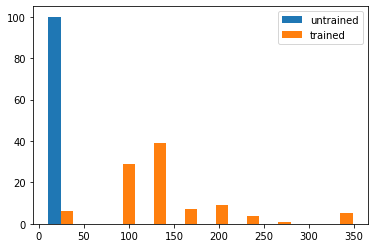

In [31]:
import matplotlib.pyplot as plt
import numpy as np

print(np.mean(learner_rewards_after_training))
print(np.mean(learner_rewards_before_training))

plt.hist(
    [learner_rewards_before_training, learner_rewards_after_training],
    label=["untrained", "trained"],
)
plt.legend()
plt.show()